In [1]:
"""
    Pro's
    1. Faster as no pretrained model is required
    2. More generic (also an con)
    
    Con's
    1. Will always detect some area even if the screen is not visible
    
    Overcoming Con's
    1. OCR can actually detect if the image cropped is valid or not.
    2. Also added an validation that the subject image should always be a 4 sided polygon
    
"""
import sys
print(sys.version)

3.10.5 (main, Jun  6 2022, 18:49:26) [GCC 12.1.0]


In [2]:
## install the packages

!pip3 install opencv-python
!pip3 install seaborn
!pip3 install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
##importing the pacakages

import cv2
import pandas
import seaborn
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

2022-07-05 11:56:45.655061: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kunal/.local/lib/python3.10/site-packages/cv2/../../lib64:
2022-07-05 11:56:45.655085: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [33]:
def image_pre_processing(image_loc, fast = False):
    
    
    image = cv2.imread(image_loc)

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 5)

    sharpen_kernel = np.array([[-1,-1,-1], [-1,10,-1], [-1,-1,-1]])
    sharpen = cv2.filter2D(blur, -1, sharpen_kernel)

    # Threshold and morph close
    thresh = cv2.threshold(sharpen, 125, 255, cv2.THRESH_BINARY_INV)[1]
    # thresh = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 145, 0)
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3,3))
    close = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel, iterations=2)

    # Find contours and filter using threshold area
    cnts = cv2.findContours(close, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]



    M = 0
    contour = 0;

    min_area = 100000
    max_area = 1500000
    image_number = 0
    for c in cnts:
        area = cv2.contourArea(c)
        if (area > M):
            M = area
            contour = c
    #     if area > min_area and area < max_area:
    #         x,y,w,h = cv2.boundingRect(c)
    #         cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)
    #         image_number += 1


    x,y,w,h = cv2.boundingRect(contour)
    approx = cv2.approxPolyDP(contour, 0.05 * cv2.arcLength(contour, True), True)
    
    if (len(approx) != 4):
        print("UNABLE TO DETECT THIS...")
        plt.imshow(image)
#         return
    
    print(len(approx))
#     cv2.rectangle(image, (x, y), (x + w, y + h), (36,255,12), 2)

    if not fast:
        fig, ax = plt.subplots(figsize=(18, 15))

        plt.subplot(2,2,1)
        im = plt.imshow(sharpen, 'gray')

        plt.subplot(2,2,2)
        im = plt.imshow(close, 'gray')

        plt.subplot(2,2,3)
        im = plt.imshow(thresh, 'gray')

        plt.subplot(2,2,4)

        crop = image[y:y+h, x:x+w]  # This is ugly but works
        im = plt.imshow(crop)

        plt.show()
    
    else:
        fig, ax = plt.subplots(figsize=(10, 5))
        
        plt.subplot(1,2,1)
        im = plt.imshow(image)
        
        plt.subplot(1,2,2)
        crop = image[y:y+h, x:x+w]  # This is ugly but works
        im = plt.imshow(crop)
        
        plt.show()

4


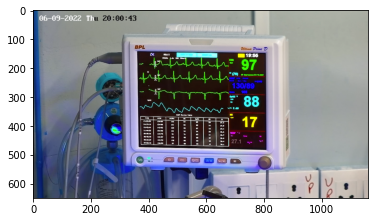

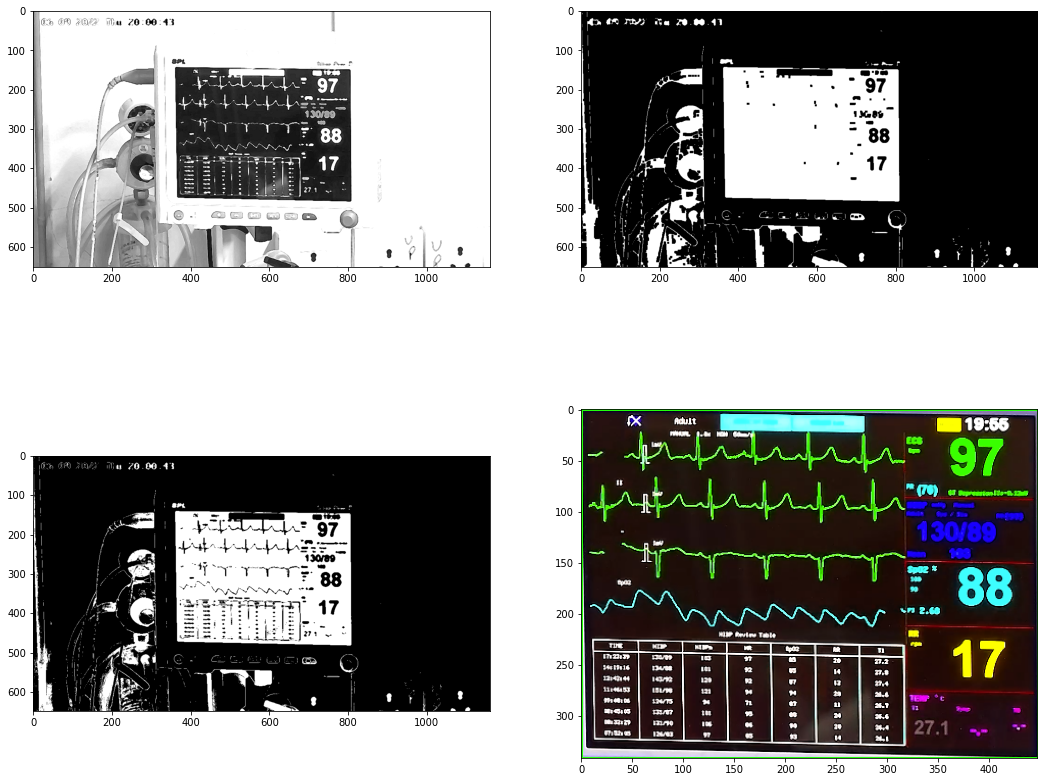

In [5]:
image_loc = "./dataset/image (2).png"
image = cv2.imread(image_loc)
plt.imshow(image)
image_pre_processing(image_loc)

In [41]:
# dir_path=r"/home/kunal/GDC/care_ocr/dataset/additional/5-para"

dir_path=r"/home/kunal/GDC/care_ocr/dataset/"

image (4).png
image (4).png
4


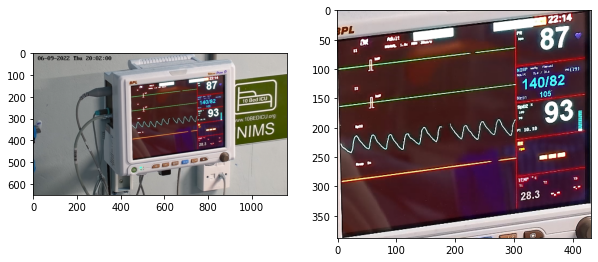

image (3).png
image (3).png
4


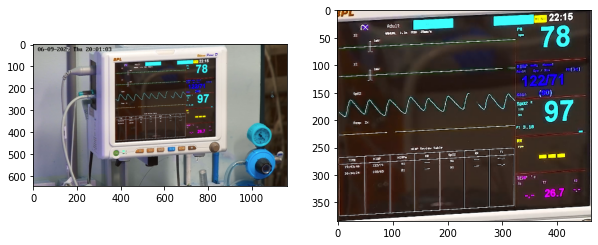

additional
image (2).png
image (2).png
4


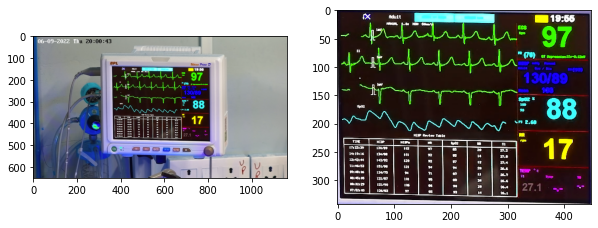

image (1).png
image (1).png
4


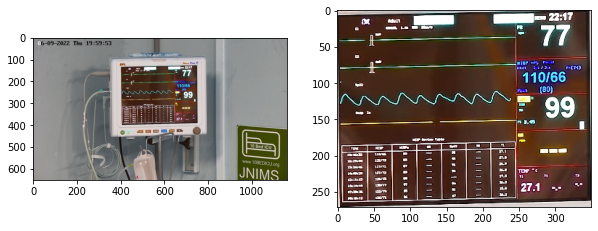

image.png
image.png
4


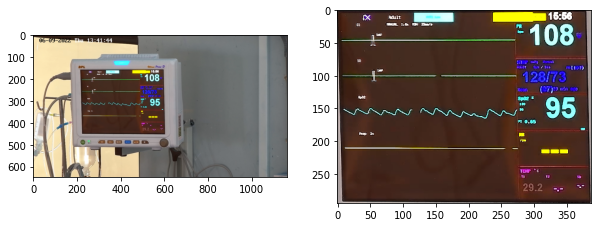

In [52]:
import os

for image in os.listdir(dir_path):
    if image[-3:] != 'jpg' and image[-3:] != "png":
          continue
    print(image)
    image_pre_processing(os.path.join(dir_path, image), True)